In [1]:
from __future__ import print_function
import tables as tb
import numpy as np
import scipy as sc
import scipy.optimize
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

import mplFunctions as mpl
import wfmFunctions as wfm
import sensorFunctions as sns
import tblFunctions as tbl

matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8) # Bigger plots
%matplotlib inline
%load_ext autoreload
%autoreload 2

print("This notebook has been run last on {} at {}.".format(time.strftime("%d/%m/%Y"),time.strftime("%H:%M:%S")))

This notebook has been run last on 06/11/2016 at 20:13:39.


# DATA CHECK

In [5]:
try:
    h5f.close()
except:
    pass

In [6]:
h5f = tb.open_file('/Users/Gonzalo/github/Shifts/data/run_2609.h5')
print(h5f)

/Users/Gonzalo/github/Shifts/data/run_2609.h5 (File) ''
Last modif.: 'Sat Nov  5 21:18:51 2016'
Object Tree: 
/ (RootGroup) ''
/BLR (Group) ''
/BLR/mau (EArray(5000, 48000), shuffle, zlib(4)) ''
/BLR/pulse_on (EArray(5000, 48000), shuffle, zlib(4)) ''
/BLR/wait_over (EArray(5000, 48000), shuffle, zlib(4)) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
/RD (Group) ''
/RD/pmtblr (EArray(11284, 12, 48000), shuffle, zlib(4)) ''
/RD/pmtcwf (EArray(5000, 12, 48000), shuffle, zlib(4)) ''
/RD/pmtrwf (EArray(11284, 12, 48000), shuffle, zlib(4)) ''
/RD/sipmrwf (EArray(11284, 1792, 1200), shuffle, zlib(4)) ''
/Run (Group) ''
/Run/event_number (EArray(11284,), shuffle, zlib(4)) ''
/Run/runInfo (Table(1,)) ''
/Sensors (Group) ''
/Sensors/DataBLR (Table(12,)) ''
/Sensors/DataPMT (Table(12,)) ''
/Sensors/DataSiPM (Table(1792,)) ''
/ZS (Group) ''
/ZS/BLR (EArray(2888, 1, 48000), shuffle, zlib(4)) ''
/ZS/PMT (EArray(2888, 1, 48000), shuffle, zlib(4)) ''
/ZS/SiPM (EArray(2888, 1792, 1

In [7]:
blrmau   = h5f.root.BLR.mau
blrpulse = h5f.root.BLR.pulse_on
blrwait  = h5f.root.BLR.wait_over

pmtcwf   = h5f.root.RD.pmtcwf
pmtblr   = h5f.root.RD.pmtblr

pmtrwf   = h5f.root.RD.pmtrwf
sipmrwf  = h5f.root.RD.sipmrwf

pmtzswf  = h5f.root.ZS.PMT
blrzswf  = h5f.root.ZS.BLR
sipmzswf = h5f.root.ZS.SiPM

pmtdf    = sns.read_data_sensors(h5f.root.Sensors.DataPMT)
blrdf    = sns.read_data_sensors(h5f.root.Sensors.DataBLR)
sipmdf   = sns.read_data_sensors(h5f.root.Sensors.DataSiPM)

In [8]:
def gauss(x, c, mu, sig):
    return c / (2*np.pi)**0.5 * np.exp(-0.5*(x-mu)**2./sig**2.)

def build_gauss(c, mu, sig):
    return lambda x: gauss(x, c, mu, sig)

# Energy spectrum

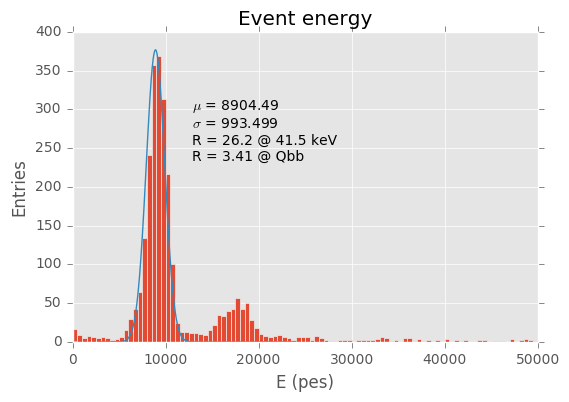

In [35]:
q = np.array([evt[0].sum() for evt in pmtzswf])
h = plt.hist(q,100,range=(0,50000))
h = [h[0], h[1][:-1], h[2]]

plt.xlabel('E (pes)')
plt.ylabel('Entries')
plt.title('Event energy')

qmin = 6000
qmax = 12000
valid = ((qmin<h[1]) & (h[1]<qmax))
x = h[1][valid]
y = h[0][valid]
fit_vals, fit_cov = sc.optimize.curve_fit(gauss, x, y, (1.,np.mean(x), np.std(x)))
const, mu, sigma = fit_vals
sigma = abs(sigma)

x = np.linspace(0.5*qmin, 2*qmax, 1000)
y = map(build_gauss(*fit_vals), x)
plt.plot(x,y)
plt.text(mu+4*sigma, const/4,
         "$\mu$ = {:g}\n$\sigma$ = "
         "{:g}\nR = {:.3} @ 41.5 keV"
         "\nR = {:.3} @ Qbb".format(mu, sigma, 235*sigma/mu, 235*sigma/mu*(41.5/2458.)**0.5))

##### Reco functions

In [36]:
def baricenter(evt, sipmdf):
    q = np.sum(evt, axis=1)
    maxq = np.max(q)
    if maxq<20.:
        return 200.,200.
    idmax = np.argmax(q)
#    return sipmdf['x'][idmax], sipmdf['y'][idmax]
    q = wfm.suppress_wf(q, maxq*0.8)
    x = np.average(sipmdf['x'], weights=q)
    y = np.average(sipmdf['y'], weights=q)
    return x, y

def inrange(evt):
    return 7000 < evt < 12000

def get_xye(pmtwf, sipmwf, sipmdf):
    E = pmtwf.sum()
    if not inrange(E):
        return 200., 200., 0.
    x, y = baricenter(sipmwf,sipmdf)
    return x, y, E

# XY event distribution

In [37]:
data = [get_xye(pmtzswf[evt], sipmzswf[evt], sipmdf) for evt in range(2888)]
data = filter(lambda x: x[0] != 200. and x[1] != 200., data)
x, y, E = map(np.array, zip(*data))

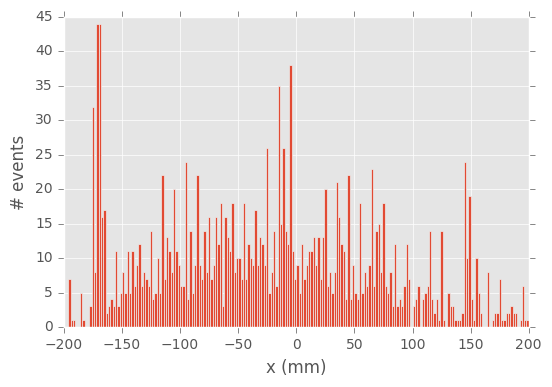

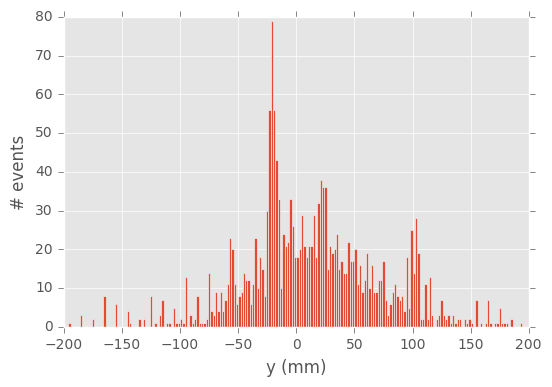

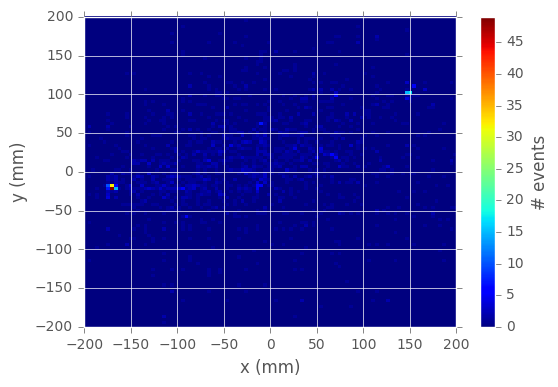

In [38]:
figx = plt.figure()
xh = plt.hist(x, 200, range=(-200,200))
plt.xlabel('x (mm)')
plt.ylabel('# events')
figy = plt.figure()
yh = plt.hist(y, 200, range=(-200,200))
plt.xlabel('y (mm)')
plt.ylabel('# events')
figxy = plt.figure()
xyh = plt.hist2d(x, y, 100, range=((-200,200),(-200,200)))
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.colorbar().set_label("# events")

# SiPMs signal for some event

x, y, E = 200.0 200.0 0.0


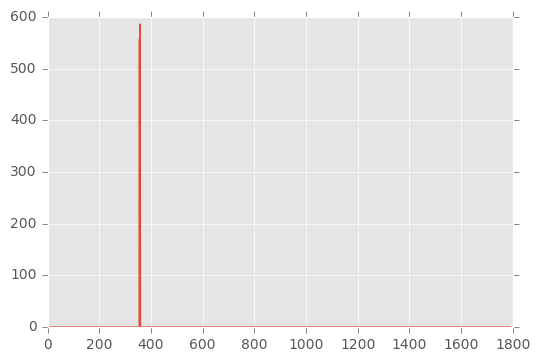

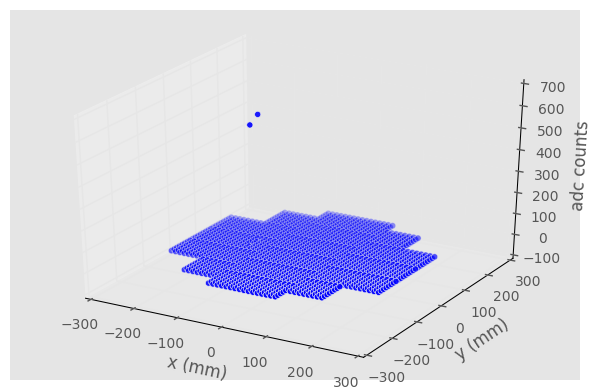

In [54]:
evt = 389
x, y, E = get_xye(pmtzswf[evt], sipmzswf[evt], sipmdf)
print("x, y, E =", x, y, E)
data = sipmzswf[evt].sum(axis=1)
data = wfm.suppress_wf(data, 0.8*np.max(data))
plt.plot(data)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sipmdf['x'], sipmdf['y'],data)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.set_zlabel("adc counts")
plt.tight_layout()